In [1]:
%matplotlib inline

from sklearn.datasets import load_files       
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

import tensorflow_datasets as tfds

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
results_path = Path('results', 'transfer_learning')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [4]:
sns.set_style('whitegrid')

#Carichiamo il dataset TensorFlow Cats vs. Dogs

In [5]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_n',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2002',
 'conll2003',
 'controlled_noisy_web_labels'

In [7]:
#usiamo un'insieme di immagini di cani e gatti per la classificazione binaria
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=[
        'train[:80%]',
        'train[80%:90%]',
        'train[90%:]'
    ],
    with_info=True,
    as_supervised=True,
    data_dir='../data/tensorflow'
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ../data/tensorflow/cats_vs_dogs/4.0.0.incompleteC161D3/cats_vs_dogs-train.tfrecord*...:   0%|       …

Dataset cats_vs_dogs downloaded and prepared to ../data/tensorflow/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [9]:
print('Raw train:\t', raw_train)
print('Raw validation:\t', raw_validation)
print('Raw test:\t', raw_test)

Raw train:	 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw validation:	 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw test:	 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


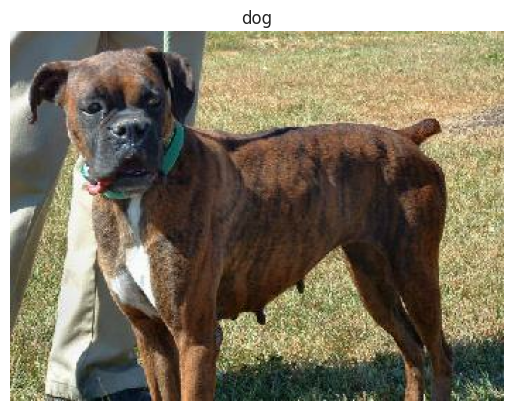

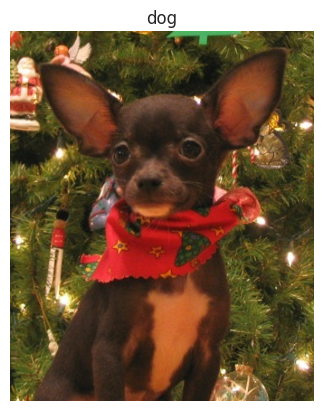

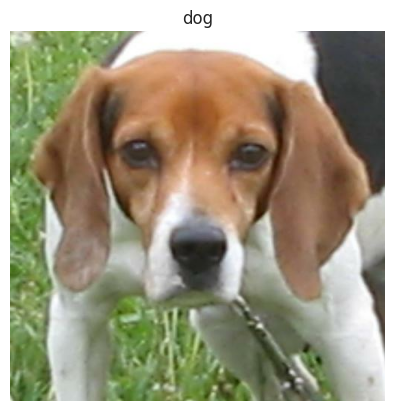

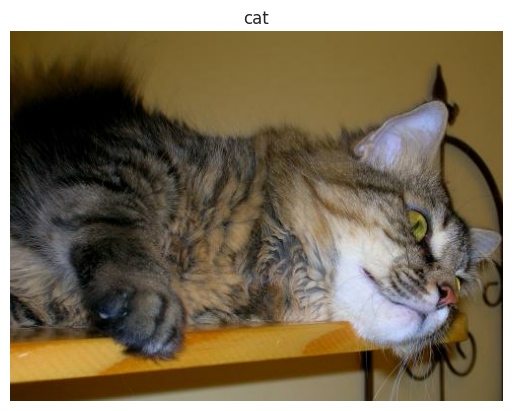

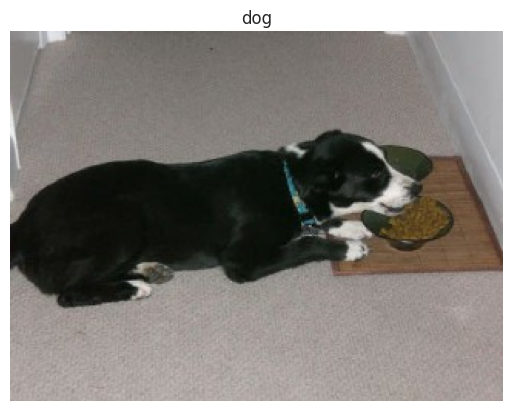

In [13]:
#mostriamo immagini dle campione
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(5):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.grid(False)
    plt.axis('off')

#Pre-elaborazione

In [14]:
#tutte le immagini vengono ridimensionate a 160x160
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [15]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [16]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [17]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [18]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [19]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

#Carichiamo le features bottleneck di VGG-16

Utilizziamo i pesi VGG16 pre-addestrati su ImageNet con i dati CIFAR10 32 x 32 molto più piccoli. Si noti che indichiamo la nuova dimensione di input al momento dell'importazione e impostiamo tutti i livelli su non addestrabili:

In [20]:
vgg16 = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
vgg16.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                              

In [21]:
feature_batch = vgg16(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

#Congeliamo i livelli del modello

In [22]:
vgg16.trainable = False
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

#Aggiungiamo nuovi strati al modello

In [23]:
global_average_layer = GlobalAveragePooling2D()
dense_layer = Dense(64, activation='relu')
dropout = Dropout(0.5)
prediction_layer = Dense(1, activation='sigmoid')

In [24]:
seq_model = tf.keras.Sequential([vgg16, 
                                 global_average_layer, 
                                 dense_layer, 
                                 dropout, 
                                 prediction_layer])

In [25]:
seq_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                       optimizer = 'Adam', 
                       metrics=["accuracy"])

In [26]:
seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,747,585
Trainable params: 32,897
Non-trainable params: 14,714,688
_______________________________________

Utilizziamo l'API funzionale di Keras per definire l'output vgg16 come input in un nuovo set di livelli completamente connessi in questo modo:

In [27]:
#Adding custom Layers 
x = vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

Definiamo un nuovo modello in termini di input e output, e da lì procediamo come prima:

In [28]:
transfer_model = Model(inputs = vgg16.input, 
                       outputs = predictions)

In [29]:
transfer_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                       optimizer = 'Adam', 
                       metrics=["accuracy"])

In [30]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [31]:
initial_epochs = 10
validation_steps=20

initial_loss, initial_accuracy = transfer_model.evaluate(validation_batches, steps = validation_steps)

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 [==============================] - 225s 11s/step - loss: 0.7202 - accuracy: 0.4625


In [32]:
print(f'Initial loss: {initial_loss:.2f} | initial_accuracy accuracy: {initial_accuracy:.2%}')

Initial loss: 0.72 | initial_accuracy accuracy: 46.25%


#Addestriamo il VGG16 transfer model

In [ ]:
history = transfer_model.fit(train_batches,
                             epochs=initial_epochs,
                             validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 6448s 11s/step - loss: 0.2431 - accuracy: 0.9002 - val_loss: 0.1596 - val_accuracy: 0.9321
Epoch 2/10
582/582 [==============================] - 6381s 11s/step - loss: 0.1677 - accuracy: 0.9312 - val_loss: 0.1514 - val_accuracy: 0.9351
Epoch 3/10
582/582 [==============================] - 6387s 11s/step - loss: 0.1543 - accuracy: 0.9376 - val_loss: 0.1473 - val_accuracy: 0.9342
Epoch 4/10
538/582 [==========================>...] - ETA: 7:11 - loss: 0.1489 - accuracy: 0.9385

In [ ]:
#plot learning curves
def plot_learning_curves(df):
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    df[['loss', 'val_loss']].plot(ax=axes[0], title='Cross-Entropy')
    df[['accuracy', 'val_accuracy']].plot(ax=axes[1], title='Accuracy')
    for ax in axes:
        ax.legend(['Training', 'Validation'])
    sns.despine()        
    fig.tight_layout();

In [ ]:
metrics = pd.DataFrame(history.history)

In [ ]:
plot_learning_curves(metrics)

#Ottimizziamo i pesi VGG16

Scongeliamo i livelli selezionati

In [ ]:
vgg16.trainable = True

In [ ]:
#Quanti livelli sono nel modello base
f'Number of layers in the base model: {len(vgg16.layers)}'

In [ ]:
# Fine-tune from this layer onwards
start_fine_tuning_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:start_fine_tuning_at]:
    layer.trainable =  False

In [ ]:
base_learning_rate = 0.0001
transfer_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
    metrics=['accuracy'])

In [ ]:
#definiamo le callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

transfer_model.summary()

#Continuiamo l'addestramento

Procediamo con l'addestramento del modello

In [ ]:
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = transfer_model.fit(train_batches,
                                       epochs=total_epochs,
                                       initial_epoch=history.epoch[-1],
                                       validation_data=validation_batches,
                                       callbacks=[early_stopping])

In [ ]:
metrics_tuned = metrics.append(pd.DataFrame(history_fine_tune.history), ignore_index=True)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics_tuned[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy Loss')
metrics_tuned[['accuracy', 'val_accuracy']].plot(ax=axes[0], title=f'Accuracy (Best: {metrics_tuned.val_accuracy.max():.2%})')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
for ax in axes:
    ax.axvline(10, ls='--', lw=1, c='k')
    ax.legend(['Training', 'Validation', 'Start Fine Tuning'])
    ax.set_xlabel('Epoch')
sns.despine()    
fig.tight_layout()
fig.savefig(results_path / 'transfer_learning');